In [1]:
import time
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from hydra import compose, initialize
from omegaconf import OmegaConf
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from src.seed import seed_everything
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)

warnings.filterwarnings("ignore")
with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config")
    cfg.exp_number = Path().resolve().name

print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


lgb:
  params:
    objective: binary
    metric: auc
    verbose: -1
    boosting_type: gbdt
    learning_rate: 0.01
    max_depth: 5
    num_leaves: 31
    min_data_in_leaf: 50
    bagging_fraction: 0.8
    bagging_freq: 1
    feature_fraction: 0.8
    lambda_l1: 0
    lambda_l2: 1
    seed: 42
  early_stopping_rounds: 100
  log_evaluation: 100
  num_boost_round: 10000000
bert:
  params:
    model_path: microsoft/deberta-v3-large
    metric: auc
    target_col_class_num: 2
    max_length: 192
    fp16: true
    learning_rate: 2.0e-05
    epochs: 2
    per_device_train_batch_size: 8
    per_device_eval_batch_size: 32
    steps: 50
    lr_scheduler_type: linear
    weight_decay: 0.01
exp_number: '007'
run_name: base
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  clothing_path: ../../data/clothing_master.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/007/base
se

In [2]:

import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from hydra import compose, initialize
from omegaconf import OmegaConf
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from src.seed import seed_everything
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)

warnings.filterwarnings("ignore")
with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config")
    cfg.exp_number = Path().resolve().name

print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


lgb:
  params:
    objective: binary
    metric: auc
    verbose: -1
    boosting_type: gbdt
    learning_rate: 0.01
    max_depth: 5
    num_leaves: 31
    min_data_in_leaf: 50
    bagging_fraction: 0.8
    bagging_freq: 1
    feature_fraction: 0.8
    lambda_l1: 0
    lambda_l2: 1
    seed: 42
  early_stopping_rounds: 100
  log_evaluation: 100
  num_boost_round: 10000000
bert:
  params:
    model_path: microsoft/deberta-v3-large
    metric: auc
    target_col_class_num: 2
    max_length: 192
    fp16: true
    learning_rate: 2.0e-05
    epochs: 2
    per_device_train_batch_size: 8
    per_device_eval_batch_size: 32
    steps: 50
    lr_scheduler_type: linear
    weight_decay: 0.01
exp_number: '007'
run_name: base
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  clothing_path: ../../data/clothing_master.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/007/base
se

### Import

In [3]:
debug = False

train_df = pd.read_csv(cfg.data.train_path)
clothing_df = pd.read_csv(cfg.data.clothing_path)
test_df = pd.read_csv(cfg.data.test_path)

if debug:
    train_df = train_df.sample(500)

def preprocess(df):
    df['importance_word'] = 'none'
    # titleとreview textを結合
    df['Title'] = df['Title'].fillna('none')
    df['Review Text'] = df['Review Text'].fillna('none')
    df['Texts'] = df['Title'] + ' ' + df['Review Text']
    df.loc[df['Texts'].str.contains('fabric', case=False), 'importance_word'] = 'fabric'
    df.loc[df['Texts'].str.contains('jeans', case=False), 'importance_word'] = 'jeans'
    df.loc[df['Texts'].str.contains('wear', case=False), 'importance_word'] = 'wear'
    df.loc[df['Texts'].str.contains('soft', case=False), 'importance_word'] = 'soft'
    df.loc[df['Texts'].str.contains('looked', case=False), 'importance_word'] = 'looked'
    df.loc[df['Texts'].str.contains('way', case=False), 'importance_word'] = 'way'
    df.loc[df['Texts'].str.contains('great', case=False), 'importance_word'] = 'great'
    df.loc[df['Texts'].str.contains('love', case=False), 'importance_word'] = 'love'
    df.loc[df['Texts'].str.contains('comfortable', case=False), 'importance_word'] = 'comfortable'
    df.loc[df['Texts'].str.contains('perfect', case=False), 'importance_word'] = 'perfect'

    print(df[df['Texts'].str.contains('perfect', case=False)]['importance_word'])
    df = df.drop('Texts', axis=1)

    # df["prompt"] = "I am " + df["Age"].map(str) + " years old" + " [SEP] " + "this review has " + df["Positive Feedback Count"].map(str)+ " positive feedback by user" + " [SEP] " + "TITLE: " + df["Title"].fillna("none") + " [SEP] " + "REVIEW: " + df["Review Text"].fillna("none")
    # df["prompt"] = "This review has " + df["Positive Feedback Count"].map(str)+ " positive feedback by user" + " [SEP] " + "TITLE: " + df["Title"].fillna("none") + " [SEP] " + "REVIEW: " + df["Review Text"].fillna("none")
    df["prompt"] =  "The cloth id to be reviewed is " + df["Clothing ID"].map(str) + " [SEP] " + "TITLE: " + df["Title"].fillna("none") + " [SEP] " + "REVIEW: " + df["Review Text"].fillna("none")
    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)
train_df["labels"] = train_df[cfg.target].astype(np.int8)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg.seed)


1       perfect
2       perfect
3       perfect
6       perfect
8       perfect
         ...   
9972    perfect
9973    perfect
9974    perfect
9987    perfect
9992    perfect
Name: importance_word, Length: 2046, dtype: object
10       perfect
14       perfect
15       perfect
17       perfect
35       perfect
          ...   
11139    perfect
11140    perfect
11143    perfect
11151    perfect
11152    perfect
Name: importance_word, Length: 2231, dtype: object


In [4]:
def compute_metrics(p):
    preds, labels = p
    preds = torch.softmax(torch.tensor(preds), dim = 1).numpy()
    score = roc_auc_score(labels, preds[:, 1])
    return {'auc': score}

# 実験結果格納用のディレクトリを作成
cfg.run_name = time.strftime("%Y%m%d_%H%M%S")
Path(cfg.data.results_dir).mkdir(exist_ok=True, parents=True)

y_train = train_df[cfg.target]
oof = np.zeros(len(train_df))

# train_df[cfg.target]が0か1かでデータを分割する
train_df['fold'] = 99
# 元のindexを保持するためにindexを新たに作成
train_df['index'] = train_df.index
train_df_0 = train_df[train_df[cfg.target] == 0].reset_index(drop=True)
train_df_1 = train_df[train_df[cfg.target] == 1].reset_index(drop=True)

# それぞれのデータフレームで、Clothing IDをtargetにstratified kfoldし、それぞれのfoldを結合する
for fold, (_, val_id) in enumerate(kf.split(train_df_0, train_df_0['importance_word'])):
    train_df_0.loc[val_id, 'fold'] = fold
for fold, (_, val_id) in enumerate(kf.split(train_df_1, train_df_1['importance_word'])):
    train_df_1.loc[val_id, 'fold'] = fold

train_df = pd.concat([train_df_0, train_df_1]).set_index('index').sort_index()

# それぞれのfoldで学習を行う
for fold in range(5):

    valid_index = train_df[train_df['fold'] == fold].index

    ds_train = Dataset.from_pandas(train_df[train_df['fold'] != fold][['prompt', 'labels']].copy())
    ds_eval = Dataset.from_pandas(train_df[train_df['fold'] == fold][['prompt', 'labels']].copy())

    # ds_trainの中身を確認
    print(ds_train)

    tokenizer = AutoTokenizer.from_pretrained(cfg.bert.params.model_path)
    config = AutoConfig.from_pretrained(cfg.bert.params.model_path)
    model = AutoModelForSequenceClassification.from_pretrained(cfg.bert.params.model_path, config=config)

    def tokenize(sample):
        return tokenizer(sample['prompt'], max_length=cfg.bert.params.max_length, truncation=True)

    ds_train = ds_train.map(tokenize).remove_columns(['prompt', 'index'])
    ds_eval = ds_eval.map(tokenize).remove_columns(['prompt', 'index'])

    output_dir = f"{cfg.data.results_dir}/fold{fold}"

    train_args = TrainingArguments(
        output_dir=output_dir,
        fp16=cfg.bert.params.fp16,
        learning_rate=cfg.bert.params.learning_rate,
        num_train_epochs=cfg.bert.params.epochs,
        per_device_train_batch_size=cfg.bert.params.per_device_train_batch_size,
        per_device_eval_batch_size=cfg.bert.params.per_device_eval_batch_size,
        gradient_accumulation_steps=4,
        report_to="none",
        evaluation_strategy="steps",
        do_eval=True,
        eval_steps=cfg.bert.params.steps,
        save_total_limit=1,
        save_strategy="steps",
        save_steps=cfg.bert.params.steps,
        logging_steps=cfg.bert.params.steps,
        load_best_model_at_end=True,
        lr_scheduler_type=cfg.bert.params.lr_scheduler_type,
        metric_for_best_model=cfg.bert.params.metric,
        greater_is_better=True,
        warmup_ratio=0.1,
        weight_decay=cfg.bert.params.weight_decay,
        save_safetensors=True,
        seed=cfg.seed,
        data_seed=cfg.seed,
    )

    trainer = Trainer(
        model=model,
        args=train_args,
        train_dataset=ds_train,
        eval_dataset=ds_eval,
        data_collator=DataCollatorWithPadding(tokenizer),
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )


    trainer.train()

    final_output_dir = f"{cfg.data.results_dir}/fold{fold}/final"
    trainer.save_model(final_output_dir)
    tokenizer.save_pretrained(final_output_dir)

    pred = torch.softmax(torch.tensor(trainer.predict(ds_eval).predictions), dim=1).numpy()
    oof[valid_index] = pred[:, 1]


Dataset({
    features: ['prompt', 'labels', 'index'],
    num_rows: 7999
})


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.504200,0.263507,0.931647
100,0.227800,0.183931,0.961167
150,0.231000,0.185553,0.962690
200,0.203300,0.180314,0.963109
250,0.187100,0.235426,0.966885
300,0.141100,0.209178,0.968747
350,0.145800,0.207735,0.969895
400,0.138700,0.181866,0.966925
450,0.137800,0.173064,0.968979
500,0.113400,0.173439,0.968464


Dataset({
    features: ['prompt', 'labels', 'index'],
    num_rows: 7999
})


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2001 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.447500,0.242773,0.955521
100,0.245600,0.200725,0.961695
150,0.213500,0.200411,0.967768
200,0.180400,0.191086,0.969350
250,0.182900,0.172321,0.970654
300,0.129500,0.194312,0.971231
350,0.120000,0.225534,0.970178
400,0.138100,0.189404,0.972220
450,0.141800,0.196199,0.972593
500,0.159700,0.169727,0.973027


Dataset({
    features: ['prompt', 'labels', 'index'],
    num_rows: 8000
})


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.455100,0.321435,0.953781
100,0.311300,0.278738,0.936206
150,0.239800,0.202784,0.964671
200,0.183300,0.209584,0.964491
250,0.191100,0.171496,0.973360
300,0.132500,0.193593,0.972303
350,0.145600,0.202721,0.973289
400,0.153200,0.187302,0.971323
450,0.152600,0.156646,0.974203
500,0.114600,0.161434,0.974558


Dataset({
    features: ['prompt', 'labels', 'index'],
    num_rows: 8001
})


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8001 [00:00<?, ? examples/s]

Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.434800,0.226114,0.940164
100,0.264000,0.189045,0.965570
150,0.196100,0.205030,0.964059
200,0.225900,0.178075,0.970061
250,0.187100,0.166814,0.970523
300,0.150500,0.198751,0.968401
350,0.136400,0.203892,0.968757
400,0.140200,0.188408,0.971414
450,0.119400,0.197155,0.971685
500,0.146200,0.187877,0.972153


Dataset({
    features: ['prompt', 'labels', 'index'],
    num_rows: 8001
})


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8001 [00:00<?, ? examples/s]

Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc
50,0.459800,0.252059,0.952603
100,0.283400,0.231116,0.920020
150,0.260400,0.295978,0.922851
200,0.223600,0.180602,0.968140
250,0.202400,0.186270,0.969209
300,0.152600,0.191771,0.968247
350,0.150300,0.191066,0.972523
400,0.162200,0.185271,0.974587
450,0.168800,0.178655,0.973987
500,0.146400,0.175168,0.974600


### oof

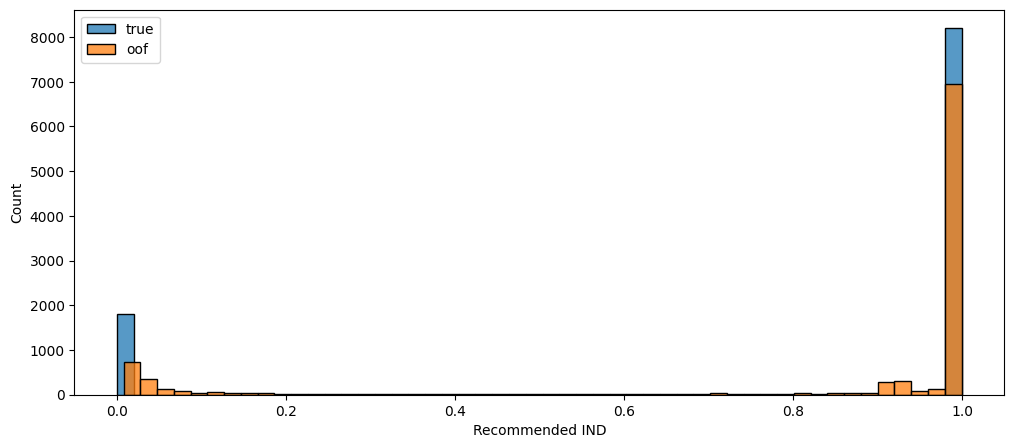

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt

oof_df = pd.DataFrame({"oof": oof})
oof_df.to_csv(f"{cfg.data.results_dir}/oof.csv", index=False)

best_score = roc_auc_score(y_train, oof)
with open(f"{cfg.data.results_dir}/log.txt", "w") as log_file:
    log_file.write("====== CV Score ======\n")
    log_file.write(f"best_score: {best_score}\n")
    log_file.write("\n====== params ======\n")
    log_file.write(OmegaConf.to_yaml(cfg, resolve=True))

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(y_train, bins=50)
sns.histplot(oof, bins=50)
plt.legend(["true", "oof"])
plt.show()
fig.savefig(f"{cfg.data.results_dir}/oof_hist.png")


### SUbmission

In [6]:
def tokenize(sample):
    return tokenizer(sample['prompt'], max_length=cfg.bert.params.max_length, truncation=True)

preds = []
for i in range(5):
    results_dir = f"{cfg.data.results_dir}/fold{i}/final"
    tokenizer = AutoTokenizer.from_pretrained(results_dir)
    model = AutoModelForSequenceClassification.from_pretrained(results_dir)

    ds_test = Dataset.from_pandas(test_df[['prompt']].copy())
    ds_test = ds_test.map(tokenize).remove_columns(['prompt'])

    test_args = TrainingArguments(
        output_dir=cfg.data.results_dir,
        per_device_eval_batch_size=cfg.bert.params.per_device_eval_batch_size,
        do_predict=True,
        dataloader_drop_last=False,
    )
    trainer = Trainer(
        model=model,
        args=test_args,
        data_collator=DataCollatorWithPadding(tokenizer),
        tokenizer=tokenizer,
    )
    predictions = torch.softmax(torch.tensor(trainer.predict(ds_test).predictions), dim=1).numpy()
    preds.append(predictions[:, 1])

pred = np.mean(preds, axis=0)

# 提出用ファイル作成
sub_df = pd.read_csv(cfg.data.sample_submission_path)
sub_df["target"] = pred
sub_df.to_csv(f"{cfg.data.results_dir}/{cfg.run_name}_submission.csv", index=False)
sub_df.head()


Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

,target
0,0.998566
1,0.286377
2,0.998584
3,0.097078
4,0.997598
